In [1]:
%matplotlib inline

import tweepy as tw
import json
import pandas as pd
import numpy as np

from collections import defaultdict, Counter
import os
from IPython.display import clear_output

import networkx as nx


import matplotlib.pyplot as plt
import seaborn as sns

from io import StringIO
from pydotplus import graph_from_dot_data
import matplotlib.image as mpimg

In [41]:
sns.set_context("poster")
sns.set_style("ticks")

In [2]:
DATA_DIR="../data"
TWITTER_CONFIG_FILE=os.path.join(DATA_DIR, "twitter_config.json")

In [3]:
if not os.path.isfile(TWITTER_CONFIG_FILE):
    with open(os.path.join(DATA_DIR, "twitter_config.sample.json")) as fp:
        creds = json.load(fp)
        for k in sorted(creds.keys()):
            v = input("Enter %s:\t" % k)
            creds[k] = v
    print(creds)
    with open(TWITTER_CONFIG_FILE, "w+") as fp:
        json.dump(creds, fp, indent=4, sort_keys=True)
    clear_output()
    print("Printed credentials to file %s" % TWITTER_CONFIG_FILE)

In [4]:
with open(TWITTER_CONFIG_FILE) as fp:
    creds = json.load(fp)
print(creds.keys())

dict_keys(['access_token', 'access_token_secret', 'consumer_key', 'consumer_secret'])


In [5]:
auth = tw.OAuthHandler(creds["consumer_key"], creds["consumer_secret"])
auth.set_access_token(creds["access_token"], creds["access_token_secret"])
api = tw.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True,
             retry_count=5, retry_delay=100, 
            )

print("Tweepy ready for search")

Tweepy ready for search


In [6]:
statuses = api.search(q=input(), count=10)

China


In [7]:
def dict2df(data):
    return pd.DataFrame(
        list(data.items()),
        columns=["item", "counts"]
    ).sort_values("counts", ascending=False)

def get_entities(statuses):
    hashtags = defaultdict(int)
    mentions = defaultdict(int)
    keys = ("hashtags", "user_mentions")
    for s in statuses:
        entities = s.entities
        if "hashtags" in entities:
            e = map(lambda x: x["text"], entities["hashtags"])
            for t in e:
                hashtags[t] += 1
        if "user_mentions" in entities:
            e = map(lambda x: x["screen_name"], entities["user_mentions"])
            for t in e:
                mentions[t] += 1
    return dict2df(hashtags), dict2df(mentions)

In [8]:
hashtags, mentions = get_entities(statuses)

In [9]:
len(statuses)

10

In [10]:
hashtags

,item,counts
0,sensoronline,1
1,China,1
2,Rússia,1


In [11]:
mentions

,item,counts
0,DwyaneWade,1
1,AereoMeteo,1
2,DamarJuniarto,1
3,AskAnshul,1
4,vicenews,1


## Current user's information

In [12]:
current_user = api.me()
current_user

User(_api=<tweepy.api.API object at 0x7fcfb050bac8>, _json={'id': 16621479, 'id_str': '16621479', 'name': 'Shubhanshu Mishra', 'screen_name': 'TheShubhanshu', 'location': 'Urbana, Illinois, USA', 'profile_location': None, 'description': 'PhD Student at @GSLIS @UIUC using data mining and ML. All my tweets can be used for data mining. I created ReadLater for Chrome https://t.co/rDKLiPfswZ', 'url': 'https://t.co/WfIGt6oMtT', 'entities': {'url': {'urls': [{'url': 'https://t.co/WfIGt6oMtT', 'expanded_url': 'http://shubhanshu.com', 'display_url': 'shubhanshu.com', 'indices': [0, 23]}]}, 'description': {'urls': [{'url': 'https://t.co/rDKLiPfswZ', 'expanded_url': 'http://goo.gl/AxnrBG', 'display_url': 'goo.gl/AxnrBG', 'indices': [128, 151]}]}}, 'protected': False, 'followers_count': 658, 'friends_count': 615, 'listed_count': 71, 'created_at': 'Mon Oct 06 22:27:27 +0000 2008', 'favourites_count': 95, 'utc_offset': -21600, 'time_zone': 'Central America', 'geo_enabled': True, 'verified': False, '

In [13]:
print(
"""Username: {}
Full Name: {}
# Followers: {}
# Friends: {}
# Statuses: {}""".format(
        current_user.screen_name,
        current_user.name,
        current_user.followers_count,
        current_user.friends_count,
        current_user.statuses_count
    )
)

Username: TheShubhanshu
Full Name: Shubhanshu Mishra
# Followers: 658
# Friends: 615
# Statuses: 3918


## Friends API

In [14]:
friends = []
for friend in tw.Cursor(api.friends, count=100).items():
    friends.append(friend)
print("{} friends found for {}".format(len(friends), current_user.name))

615 friends found for Shubhanshu Mishra


In [15]:
df_friends = pd.DataFrame(
    list(map(
        lambda k: (k.id, k.name, k.friends_count, k.followers_count, k.statuses_count),
        friends
    )), columns=["id", "name", "friends", "followers", "statuses"]
).sort_values("followers", ascending=False).reset_index(drop=True)
df_friends.head()

,id,name,friends,followers,statuses
0,813286,Barack Obama,628999,91975795,15450
1,50393960,Bill Gates,183,36249061,2423
2,88856792,Aamir Khan,9,21426245,475
3,822215679726100480,President Trump,42,19411685,900
4,20536157,Google,205,18428159,73344


In [16]:
network = np.zeros([df_friends.shape[0], df_friends.shape[0]])
network.shape

(615, 615)

In [17]:
api.show_friendship?

In [18]:
tw.__version__

'3.5.0'

In [19]:
def get_friendship(id1, id2, verbose=False):
    response = api.show_friendship(source_id=id1, target_id=id2)
    if verbose:
        print(response)
    return response[0].following, response[1].following
    

In [20]:
get_friendship(df_friends["id"].values[0], df_friends["id"].values[1], verbose=True)

(Friendship(_api=<tweepy.api.API object at 0x7fcfb050bac8>, id=813286, id_str='813286', screen_name='BarackObama', following=False, followed_by=True, live_following=False, following_received=None, following_requested=None, notifications_enabled=None, can_dm=True, blocking=None, blocked_by=None, muting=None, want_retweets=None, all_replies=None, marked_spam=None), Friendship(_api=<tweepy.api.API object at 0x7fcfb050bac8>, id=50393960, id_str='50393960', screen_name='BillGates', following=True, followed_by=False, following_received=None, following_requested=None))


(False, True)

In [21]:
network[0, 0] = False
network[1, 0] = True
network[0:3, 0]

array([ 0.,  1.,  0.])

In [22]:
def generate_ego_network(df_friends):
    network = np.zeros([df_friends.shape[0], df_friends.shape[0]])
    processed_friendships=0
    for i, fid1 in enumerate(df_friends["id"].values):
        for j, fid2 in enumerate(df_friends["id"].values[i+1:], start=i+1):
            try:
                tie_labels = get_friendship(fid1, fid2)
                processed_friendships += 1
            except:
                print("Processed friendships = {}".format(processed_friendships))
                print("Error occurred")
                return network
            network[i, j] = tie_labels[0]
            network[j, i] = tie_labels[1]
    return network

In [23]:
df_friends.tail()

,id,name,friends,followers,statuses
610,709866998604419072,ICSS2016,15,19,28
611,217524967,Shubhanshu Mishra,3,12,382
612,862776294441984000,Christopher De Sa,8,11,1
613,492698838,LiveLifeLikeAJive,9,1,0
614,4330080442,Sudhanshu Mishra,21,1,0


## Generate user mention network

In [24]:
statuses = [status for status in tw.Cursor(api.search, q=input(), count=1000).items(1000)]

Donald Trump


In [25]:
len(statuses)

1000

In [26]:
status = next(filter(lambda x: len(x.entities["hashtags"]), statuses))

In [27]:
status.entities

{'hashtags': [{'indices': [112, 126], 'text': 'RespectMyVote'}],
 'symbols': [],
 'urls': [],
 'user_mentions': [{'id': 525925642,
   'id_str': '525925642',
   'indices': [3, 14],
   'name': 'Buddy #DemForce',
   'screen_name': 'MrBudSmith'}]}

In [28]:
def get_hashtags(statuses):
    hashtag_counts = defaultdict(int)
    hashtag_network = defaultdict(int)
    for status in statuses:
        for i, hashtag in enumerate(status.entities["hashtags"]):
            hashtag_counts[hashtag["text"]] += 1
            for j, hashtag_2 in enumerate(status.entities["hashtags"][i+1:], start=i+1):
                hashtag_network[(hashtag["text"],hashtag_2["text"])] += 1
    return hashtag_counts, hashtag_network

In [29]:
hashtag_counts, hashtag_network = get_hashtags(statuses)

In [30]:
df_hashtags = pd.DataFrame(list(hashtag_counts.items()),
                           columns=["hashtag", "counts"]).sort_values(
    "counts", ascending=False
).reset_index(drop=True)
df_hashtags.head()

,hashtag,counts
0,TrumpRussia,20
1,RespectMyVote,19
2,Trump,10
3,DonaldTrump,7
4,EpicFail,7


In [31]:
df_hashtags = pd.DataFrame(list(hashtag_counts.items()),
                           columns=["hashtag", "counts"]).sort_values(
    "counts", ascending=False
).reset_index(drop=True)
df_hashtags.head()

,hashtag,counts
0,TrumpRussia,20
1,RespectMyVote,19
2,Trump,10
3,DonaldTrump,7
4,EpicFail,7


In [32]:
df_hashtag_pairs = pd.DataFrame([(k1, k2, v) for (k1,k2), v in hashtag_network.items()],
                           columns=["hashtag1", "hashtag2", "counts"]).sort_values(
    "counts", ascending=False
).reset_index(drop=True)
df_hashtag_pairs.head()

,hashtag1,hashtag2,counts
0,Trumpcare,EpicFail,7
1,GOPhealthcare,Trumpcare,7
2,GOPhealthcare,EpicFail,7
3,Trump,DonaldTrump,3
4,pictures,Trump,3


## Plot network

In [34]:
G = nx.Graph()

In [36]:
G.add_nodes_from(hashtag_counts)

In [39]:
G.add_edges_from([
    (k[0], k[1], {"weight": v})
    for k, v in hashtag_network.items()
])

(-0.098458876381625468,
 1.1019533266773878,
 -0.10400457878596207,
 1.103695761756587)

/home/napsternxg/anaconda3/envs/get17_sna/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


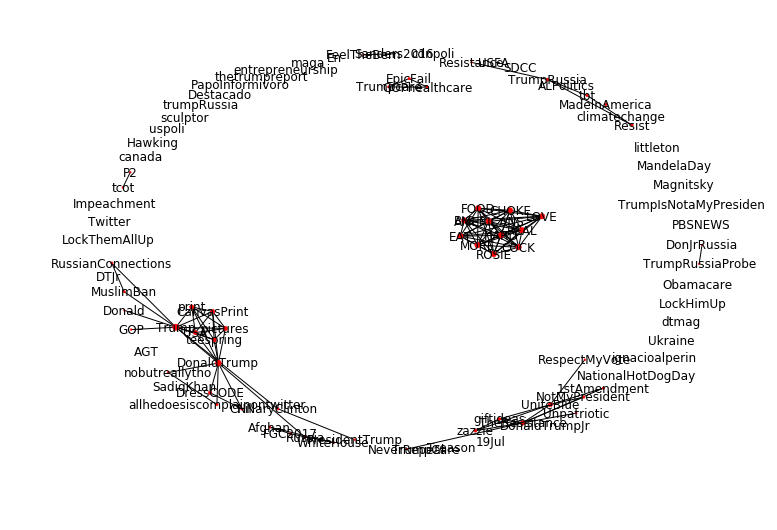

In [43]:
fig, ax = plt.subplots(1,1)
nx.draw_networkx(
    G, with_labels=True,
    node_size=[x[1]*3 for x in G.degree_iter()],
    pos=nx.spring_layout(G),
    ax=ax
)
ax.axis("off")

In [44]:
connected_components = sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
print("{} connected components found.".format(len(connected_components)))

47 connected components found.


(-0.10500000000000001, 1.105, -0.098346338622802648, 1.0349781350304468)

/home/napsternxg/anaconda3/envs/get17_sna/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


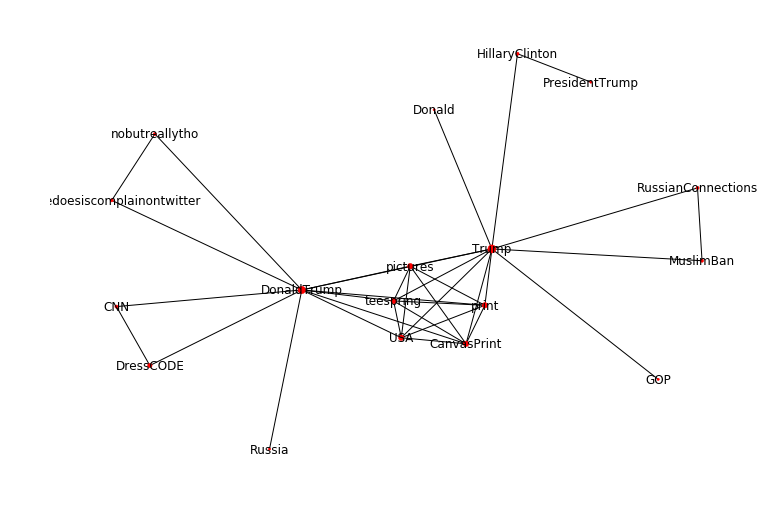

In [46]:
fig, ax = plt.subplots(1,1)
nx.draw_networkx(
    connected_components[0], with_labels=True,
    node_size=[x[1]*5 for x in connected_components[0].degree_iter()],
    pos=nx.spring_layout(connected_components[0]),
    ax=ax
)
ax.axis("off")